In [1]:
!pip install split-folders

### **Importing of Necessary Libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image, ImageEnhance
import random
import splitfolders
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
!pip install wandb --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 69.3 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.1
    Uninstalling wandb-0.18.1:
      Successfully uninstalled wandb-0.18.1


In [4]:
import wandb
from wandb.integration.keras import WandbCallback

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api_key")


### **Dataset Loading and Splitting**
Split-folders library was used to split the dataset into three parts: Training set(60%), Validation set(20%), and Test set(20%).

In [5]:
# Paths
base_ds = '/kaggle/input/potato-2nd-revision/Potato2ndrev/Potato_Leaf_Disease_Dataset_in_Uncontrolled_Environment'
output_dir = '/kaggle/working/imgs'

In [6]:
splitfolders.ratio(base_ds, output=output_dir, seed=123, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 3076 files [00:22, 137.66 files/s]


In [7]:
augmentations_needed = {
    'Nematode': {
        'count': 36,
        'augmentations': [
            'rotation_range', 'horizontal_flip', 'brightness', 'color_jitter', 'contrast', 'zoom_range', 'translate', 'small_noise',
            'rotation_range + horizontal_flip', 'rotation_range + brightness', 'horizontal_flip + brightness', 'color_jitter + contrast',
            'translate + brightness', 'zoom_range + color_jitter', 'color_jitter + vertical_flip', 'horizontal_flip + small_noise',
            'rotation_range + small_noise', 'translate + color_jitter', 'brightness + small_noise', 'horizontal_flip + zoom_range',
            'brightness + contrast', 'horizontal_flip + color_jitter', 'translate + zoom_range', 'zoom_range + small_noise',
            'horizontal_flip + translate', 'brightness + color_jitter', 'contrast + small_noise', 'color_jitter + small_noise',
            'horizontal_flip + contrast', 'translate + small_noise', 'rotation_range + zoom_range', 'brightness + zoom_range',
            'rotation_range + contrast', 'vertical_flip + brightness', 'contrast + zoom_range', 'rotation_range + color_jitter'
        ]
    },
    'Healthy': {
        'count': 13,
        'augmentations': [
            'rotation_range', 'zoom_range', 'horizontal_flip', 'brightness', 'color_jitter', 'contrast', 'small_noise',
            'rotation_range + brightness', 'horizontal_flip + color_jitter', 'zoom_range + contrast', 'brightness + small_noise',
            'horizontal_flip + small_noise', 'color_jitter + contrast'
        ]
    },
    'Phytopthora': {
        'count': 8,
        'augmentations': [
            'rotation_range', 'horizontal_flip', 'brightness', 'color_jitter', 
            'contrast', 'zoom_range', 'translate', 'vertical_flip'
        ]
    },
    'Bacteria': {
        'count': 4,
        'augmentations': [
            'rotation_range', 'horizontal_flip', 'translate', 'small_noise'
        ]
    },
    'Fungi': {
        'count': 3,
        'augmentations': [
            'rotation_range', 'zoom_range', 'color_jitter'
        ]
    },
    'Pest': {
        'count': 4,
        'augmentations': [
            'small_noise', 'rotation_range', 'horizontal_flip', 'color_jitter'
        ]
    },
    'Virus': {
        'count': 4,
        'augmentations': [
            'color_jitter', 'horizontal_flip', 'rotation_range', 'translate'
        ]
    }
}


In [8]:
# Import required libraries
from PIL import ImageEnhance, ImageOps, Image
import numpy as np
import random
import os
import zipfile  # Ensure zipfile is imported
import zipfile
import os
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random


In [9]:
from PIL import ImageEnhance, ImageOps
import numpy as np
import random

# Custom augmentation functions, updated to include new augmentations
def apply_custom_augmentations(image, aug_type):
    # Apply individual augmentations
    if aug_type == 'brightness':
        enhancer = ImageEnhance.Brightness(image)
        aug_image = enhancer.enhance(random.uniform(0.9, 1.1))
    elif aug_type == 'color_jitter':
        enhancer = ImageEnhance.Color(image)
        aug_image = enhancer.enhance(random.uniform(0.8, 1.2))
    elif aug_type == 'contrast':
        enhancer = ImageEnhance.Contrast(image)
        aug_image = enhancer.enhance(random.uniform(0.9, 1.1))
    elif aug_type == 'noise':
        image_array = np.array(image)
        noise = np.random.normal(0, 0.05 * 255, image_array.shape)
        aug_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)
        aug_image = Image.fromarray(aug_image)
    elif aug_type == 'small_noise':  # Introduce mild noise
        image_array = np.array(image)
        noise = np.random.normal(0, 0.02 * 255, image_array.shape)  # Smaller noise factor
        aug_image = np.clip(image_array + noise, 0, 255).astype(np.uint8)
        aug_image = Image.fromarray(aug_image)
    elif aug_type == 'rotation_range':
        angle = random.uniform(-10, 10)  # Adjusted random rotation between -10 and 10 degrees
        aug_image = image.rotate(angle)
    elif aug_type == 'zoom_range':
        zoom_factor = random.uniform(0.85, 1.15)  # Random zoom in/out
        width, height = image.size
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        aug_image = image.resize((new_width, new_height))
        # Crop to original size
        aug_image = aug_image.crop((0, 0, width, height))
    elif aug_type == 'horizontal_flip':
        aug_image = ImageOps.mirror(image)
    elif aug_type == 'vertical_flip':
        aug_image = ImageOps.flip(image)
    elif aug_type == 'width_shift_range':
        max_shift = int(0.2 * image.size[0])  # Max shift is 20% of image width
        shift = random.randint(-max_shift, max_shift)
        aug_image = Image.fromarray(np.roll(np.array(image), shift, axis=1))
    elif aug_type == 'translate':
        max_shift_x = int(0.1 * image.size[0])  # Max shift is 10% of image width
        max_shift_y = int(0.1 * image.size[1])  # Max shift is 10% of image height
        shift_x = random.randint(-max_shift_x, max_shift_x)
        shift_y = random.randint(-max_shift_y, max_shift_y)
        aug_image = Image.fromarray(np.roll(np.roll(np.array(image), shift_x, axis=1), shift_y, axis=0))
    
    # Apply combined augmentations
    elif '+' in aug_type:
        aug1, aug2 = aug_type.split('+')
        aug1, aug2 = aug1.strip(), aug2.strip()
        aug_image = apply_custom_augmentations(image, aug1)  # Apply the first augmentation
        aug_image = apply_custom_augmentations(aug_image, aug2)  # Apply the second augmentation
    else:
        aug_image = image  # In case an unknown augmentation is passed

    return aug_image


In [10]:
# Apply augmentations to the training set and save augmented images
train_dir = os.path.join(output_dir, 'train')
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    save_to_dir = os.path.join(class_dir)
    os.makedirs(save_to_dir, exist_ok=True)

    # Check if the class requires augmentation
    if class_name in augmentations_needed:
        images = os.listdir(class_dir)
        augmentations_per_image = augmentations_needed[class_name]['count']
        augmentation_types = augmentations_needed[class_name]['augmentations']
        
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            image = load_img(img_path)
            
            for i in range(augmentations_per_image):
                # Randomly select an augmentation
                selected_aug = random.choice(augmentation_types)
                
                # Apply the selected augmentation
                aug_img = apply_custom_augmentations(image, selected_aug)
                
                # Save the augmented image with a unique name to avoid overwriting
                aug_img.save(os.path.join(save_to_dir, f'aug_{img_name.split(".")[0]}_{i}.jpeg'))
    else:
        print(f"No augmentation needed for class: {class_name}")


In [11]:
# Count images in the augmented dataset
augmented_dir = pathlib.Path(output_dir)

In [12]:
Bacteria = [fn for fn in os.listdir(f'{augmented_dir}/train/Bacteria') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Fungi = [fn for fn in os.listdir(f'{augmented_dir}/train/Fungi') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Healthy = [fn for fn in os.listdir(f'{augmented_dir}/train/Healthy') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Nematode = [fn for fn in os.listdir(f'{augmented_dir}/train/Nematode') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Pest = [fn for fn in os.listdir(f'{augmented_dir}/train/Pest') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Phytopthora = [fn for fn in os.listdir(f'{augmented_dir}/train/Phytopthora') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]
Virus = [fn for fn in os.listdir(f'{augmented_dir}/train/Virus') if (fn.endswith('.JPG') or fn.endswith('.jpg') or fn.endswith('.jpeg'))]

coffee = [Bacteria, Fungi, Healthy, Nematode, Pest, Phytopthora, Virus]
coffee_classes = [class_name for class_name in os.listdir(f'{augmented_dir}/train') if os.path.isdir(f'{augmented_dir}/train/{class_name}')]
coffee_classes.sort()

In [13]:
image_count = sum([len(group) for group in coffee])
print(f'Total images in the augmented training set: {image_count}')
print(f'Total number of classes: {len(coffee_classes)}')

Total images in the augmented training set: 13954
Total number of classes: 7


In [14]:
import os

# Define the base directory
base_dir = '/kaggle/input/potato-2nd-revision/Potato2ndrev/Potato_Leaf_Disease_Dataset_in_Uncontrolled_Environment'

# Initialize a counter for the total number of images
total_images = 0

# Iterate over all subdirectories and count images
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        image_count = len([f for f in os.listdir(folder_path) if f.endswith(('.JPG','.jpg', '.jpeg', '.png'))])
        total_images += image_count
        print(f'{folder}: {image_count} images')

# Print the total number of images
print(f'Total number of images: {total_images}')


Nematode: 68 images
Bacteria: 569 images
Healthy: 201 images
Phytopthora: 347 images
Fungi: 748 images
Pest: 611 images
Virus: 532 images
Total number of images: 3076


Total Bacteria images: 1990
Total Fungi images: 2092
Total Healthy images: 1960
Total Nematode images: 1739
Total Pest images: 2135
Total Phytopthora images: 2178
Total Virus images: 1860


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


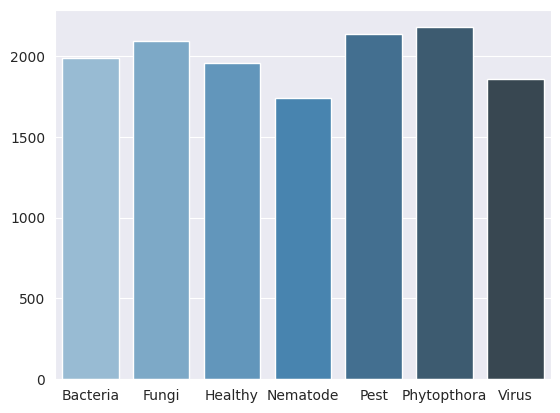

In [15]:
# Count images per class and plot
coffee_count = []
for class_name, image_group in zip(coffee_classes, coffee):
    print(f'Total {class_name} images: {len(image_group)}')
    coffee_count.append(len(image_group))

sns.set_style('darkgrid')
sns.barplot(x=coffee_classes, y=coffee_count, palette="Blues_d")
plt.show()

Image dimensions: (1500, 1500, 3)


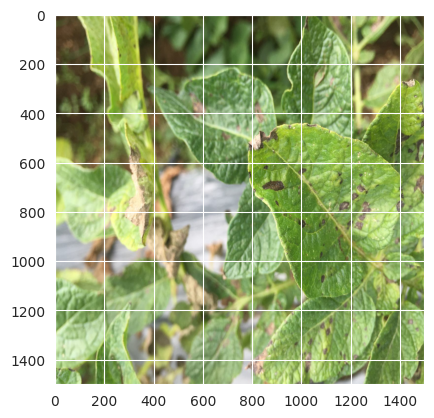

In [16]:
# Display a sample image from the augmented dataset
sample_img_path = os.path.join(augmented_dir, 'train', 'Fungi', random.choice(Fungi))
sample_img = cv2.imread(sample_img_path)
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
print(f'Image dimensions: {sample_img.shape}')

### **Dataset Exploration**
It can be seen here the total number of images in the dataset, the number of classes, and how well the images from each variety is distributed

### Sample Images
Each image from the dataset has a dimension of 250 by 250 and a color type of RGB

Image dimensions: (1500, 1500, 3)


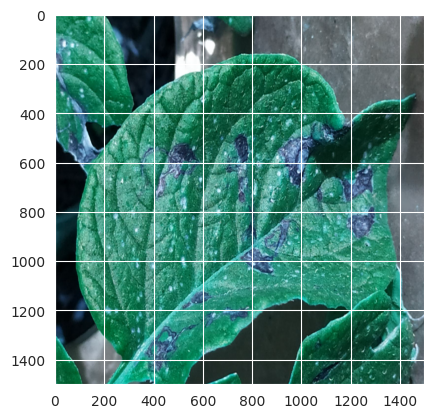

In [17]:
sample_img = cv2.imread('/kaggle/input/potato-2nd-revision/Potato2ndrev/Potato_Leaf_Disease_Dataset_in_Uncontrolled_Environment/Fungi/1692332350583.jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [18]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in coffee_classes:
    i+=1
    plt.subplot(1,7, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

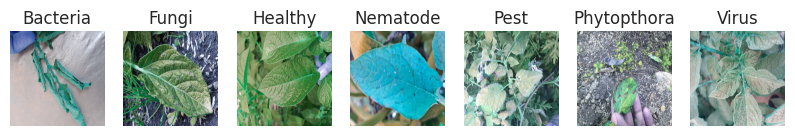

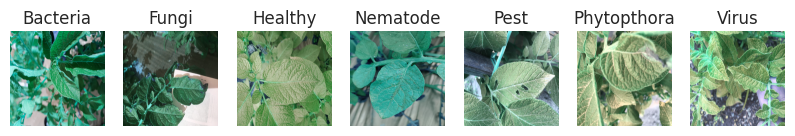

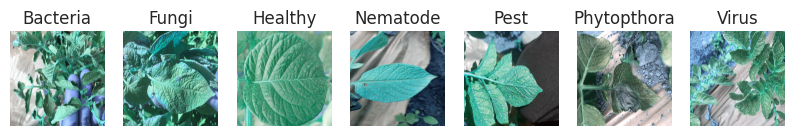

In [19]:
for i in range(3):
  load_random_img(base_ds,coffee_classes)

In [20]:
batch_size =16
img_height, img_width =128,128
input_shape = (img_height, img_width, 3)

CONFIG=dict(
            batch_size =16,
            img_height=128,
            img_width =128,
            )

### **Data Pre-processing**

In [21]:
# Use ImageDataGenerator to read images from the working directory
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_ds = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_ds = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_ds = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 13954 images belonging to 7 classes.
Found 612 images belonging to 7 classes.
Found 315 images belonging to 7 classes.


In [23]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
import wandb
import pathlib
from tensorflow.keras import regularizers

In [25]:
CONFIG['model_name'] = 'DenseNet201'
print('Training configuration: ', CONFIG)

# Initialize W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='potato_large_aug',
                 entity="pritmhala03",
                 config=CONFIG,
                 group='DenseNet201', 
                 job_type='train')

wandb.config.type = 'baseline'

Training configuration:  {'batch_size': 16, 'img_height': 128, 'img_width': 128, 'model_name': 'DenseNet201'}


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## **Transfer Learning**

In [26]:
model=tf.keras.applications.DenseNet201(weights="imagenet", include_top=False, input_shape=input_shape)
model.trainable = True
inputs = tf.keras.Input(input_shape)
x = model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add fully connected layers with L2 regularization
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.001))(x)

model= tf.keras.Model(inputs, x)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [27]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 4, 4, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,967,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,296,263 (77.42 MB)

 Trainable params: 20,067,207 (76.55 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [28]:
metrics_logger = WandbMetricsLogger()
model_checkpoint = WandbModelCheckpoint(filepath='model_checkpoint.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


## **Fine Tuning**

In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss to trigger early stopping
    patience=3,          # Stop after 3 epochs of no improvement
    restore_best_weights=True  # Restore the best weights (best validation loss)
)

# Fine Tuning with Early Stopping
history3 = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    callbacks=[metrics_logger, model_checkpoint, early_stopping]  # Add early_stopping to the callbacks
)

run.finish()

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728583842.135682     167 service.cc:145] XLA service 0x7e012c005f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728583842.135767     167 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728583842.135774     167 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1728583978.506002     167 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_slice_fusion', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are s

873/873 ━━━━━━━━━━━━━━━━━━━━ 550s 357ms/step - accuracy: 0.5305 - loss: 2.5839 - val_accuracy: 0.7059 - val_loss: 1.8347
Epoch 2/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 169s 192ms/step - accuracy: 0.9326 - loss: 1.2433 - val_accuracy: 0.7582 - val_loss: 1.4968
Epoch 3/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 172s 195ms/step - accuracy: 0.9835 - loss: 0.8803 - val_accuracy: 0.7680 - val_loss: 1.3688
Epoch 4/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 174s 197ms/step - accuracy: 0.9946 - loss: 0.7212 - val_accuracy: 0.7827 - val_loss: 1.3238
Epoch 5/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 170s 193ms/step - accuracy: 0.9971 - loss: 0.6369 - val_accuracy: 0.7712 - val_loss: 1.3064
Epoch 6/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 164s 186ms/step - accuracy: 0.9982 - loss: 0.5824 - val_accuracy: 0.7761 - val_loss: 1.3016
Epoch 7/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 160s 181ms/step - accuracy: 0.9977 - loss: 0.5468 - val_accuracy: 0.7712 - val_loss: 1.3041
Epoch 8/20
873/873 ━━━━━━━━━━━━━━━━━━━━ 165s 187ms/step - accuracy: 0.9984 - loss: 0.51

epoch/accuracy,▁▇███████
epoch/epoch,▁▂▃▄▅▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁
epoch/val_accuracy,▁▆▇█▇▇▇▇█
epoch/val_loss,█▄▂▁▁▁▁▁▁
epoch/accuracy,0.99878
epoch/epoch,8
epoch/learning_rate,1e-05
epoch/loss,0.47662
epoch/val_accuracy,0.78105


## **Final Evaluation**

In [30]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='l2norm_earlystop_2ndrev', 
                 config=CONFIG,
                 group='DenseNet201', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


wandb: Currently logged in as: pritmhala03. Use `wandb login --relogin` to force relogin


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 836ms/step - accuracy: 0.8060 - loss: 1.2754


Pretrained Network Fine-tuned
Loss: 1.3507, Accuracy: 77.14%


In [31]:
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='l2norm_earlystop_2ndrev', 
                 config=CONFIG,
                 group='DenseNet201', 
                 job_type='evaluate') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Evaluate model
score3 =model.evaluate(test_ds, verbose=1)

# Finish the run
run.finish()

print(f'Pretrained Network Fine-tuned\nLoss: {score3[0]:.4f}, Accuracy: {score3[1] * 100:.2f}%')


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.8060 - loss: 1.2754


Pretrained Network Fine-tuned
Loss: 1.3507, Accuracy: 77.14%


In [32]:
print(f'Pretrained Network Fine-tuned "\n"Loss: {score3[0]},"\n" Accuracy: {score3[1]*100}')

Pretrained Network Fine-tuned "
"Loss: 1.3507317304611206,"
" Accuracy: 77.14285850524902


In [33]:
Y_pred =model.predict(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 886ms/step


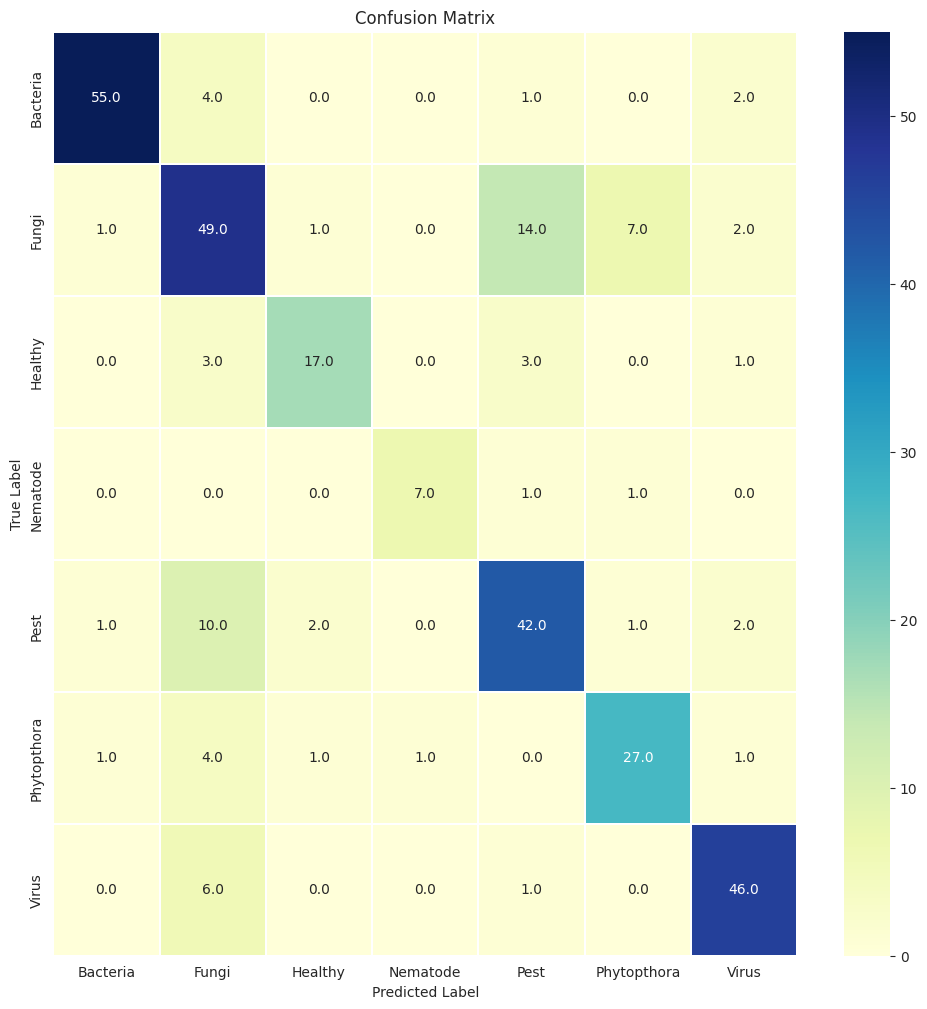

In [34]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,
           cmap="YlGnBu",)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(coffee_classes)
plt.title("Confusion Matrix")
plt.show()

In [35]:
report2 = classification_report(test_ds.classes, y_pred, target_names=coffee_classes, output_dict=True)
df2 = pd.DataFrame(report2).transpose()
df2

,precision,recall,f1-score,support
Bacteria,0.887097,0.948276,0.916667,58.000000
Fungi,0.662162,0.644737,0.653333,76.000000
Healthy,0.708333,0.809524,0.755556,21.000000
Nematode,0.777778,0.875000,0.823529,8.000000
Pest,0.724138,0.677419,0.700000,62.000000
Phytopthora,0.771429,0.750000,0.760563,36.000000
Virus,0.867925,0.851852,0.859813,54.000000
accuracy,0.771429,0.771429,0.771429,0.771429
macro avg,0.771266,0.793830,0.781352,315.000000
weighted avg,0.769553,0.771429,0.769794,315.000000


In [ ]:
model.save('DenseNet201-baseline.h5')

# Initialize a new W&B run
run = wandb.init(settings=wandb.Settings(start_method="fork"),
                 reinit=True,
                 project='l2norm_earlystop_2ndrev', 
                 config=CONFIG,
                 group='DenseNet201', 
                 job_type='save') # Note the job_type

# Update `wandb.config`
wandb.config.type = 'baseline'

# Save model as Model Artifact
artifact = wandb.Artifact(name='EfficientNetV2', type='model')
artifact.add_file('DenseNet201-baseline.h5')
run.log_artifact(artifact)

# Finish W&B run
run.finish()




<h2>Support by giving an upvote!!</h2>